# Gaussian Processes

In this tutorial we show how to draw a non-uniform `spotter` map (e.g. one covered in [starspots](https://en.wikipedia.org/wiki/Sunspot)) using a Gaussian Process (GP) on the sphere.

```{note}
GPs in `spotter` are defined and computed using the [tinygp](https://tinygp.readthedocs.io/en/stable/) Python package. For more details about GPs on the sphere, check out the [Custom Geometry](https://tinygp.readthedocs.io/en/stable/tutorials/geometry.html) `tinygp` tutorial.
```

The main idea is that a 1D Gaussian Process can be easily defined on the sphere, using the [great circle distance](https://en.wikipedia.org/wiki/Great-circle_distance) as the distance metric in the GP kernel.

## Isotropic kernel

In this first example, we define a kernel to draw a stellar surface uniformly covered with active regions, such as starspots.

We start by defining the properties of our stellar surface with few variables

In [1]:
from spotter.experimental.core import vec

N = 2**4  # number of sides
u = (0.4, 0.1)  # limb darkening coefficient
X = vec(N)  # pixels coordinates

We can then use `tinygp` to define an isotropic kernel on the sphere

In [2]:
import tinygp
from spotter.experimental.kernels import GreatCircleDistance

kernel = 0.1 * tinygp.kernels.Matern52(0.4, distance=GreatCircleDistance())
gp = tinygp.GaussianProcess(kernel, X)

and draw a surface from it

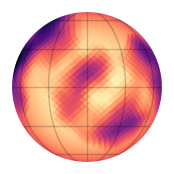

In [3]:
import jax
import matplotlib.pyplot as plt
from spotter.experimental import viz

y = gp.sample(jax.random.PRNGKey(4), shape=(1,))[0]
y = 1.0 - y.clip(0.0, 1.0)

plt.figure(figsize=(2, 2))
viz.show(y, inclination=0.0, u=u)

```{note}
Any other GP library allowing a custom distance metric can be used in combination with `spotter` to draw surfaces on the sphere.
``` 


The GP we just built model active regions with sizes related to the kernel length scale. Let's show surfaces drawn from kernels with different length scales

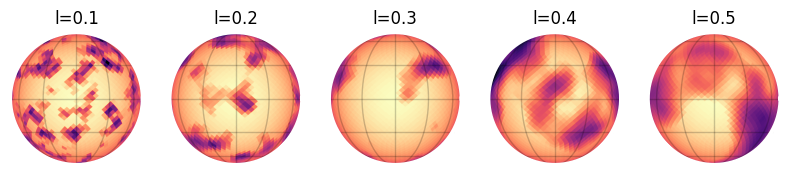

In [4]:
from matplotlib import gridspec

lenght_scales = [0.1, 0.2, 0.3, 0.4, 0.5]
gridspec.GridSpec(1, 6)
plt.figure(figsize=(12, 2))

for i, l in enumerate(lenght_scales):
    kernel = 0.1 * tinygp.kernels.Matern52(l, distance=GreatCircleDistance())
    gp = tinygp.GaussianProcess(kernel, X)
    y = gp.sample(jax.random.PRNGKey(i + 1), shape=(1,))[0]
    y = 1.0 - y.clip(0.0, 1.0)
    plt.subplot(1, 6, i + 1)
    viz.show(y, inclination=0.0, u=u)
    plt.title(f"l={l}")

## Active latitudes

As [seen on the sun](https://en.wikipedia.org/wiki/Solar_cycle), active regions can be preferentially located at certain latitudes. In order to draw surfaces with such properties, `spotter` features the `ActiveLatitude` kernel (non-isotropic!).

This kernel takes an isotropic kernel as input, which sets the active regions properties, as well as their preferred latitude and the standard deviation of the latitude band where they are located.

In [5]:
from spotter.experimental import kernels

kernel = kernels.ActiveLatitude(
    kernel=0.1 * tinygp.kernels.Matern52(0.3, distance=kernels.GreatCircleDistance()),
    latitude=0.5,
    sigma=0.2,
    symetric=True,
)

gp = tinygp.GaussianProcess(kernel, X)

We can plot the distribution of active regions along $\cos{\theta}$

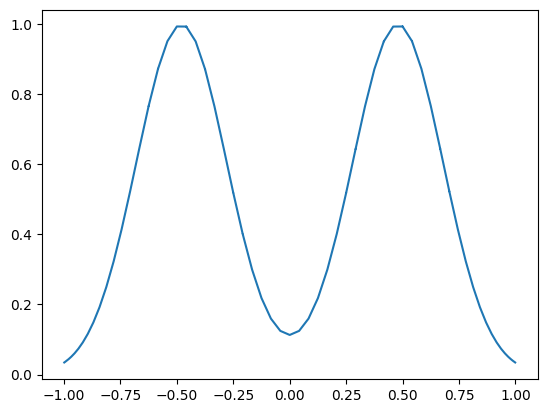

In [6]:
import jax.numpy as jnp

cos_theta = X.T[2] / jnp.linalg.norm(X.T, axis=0)
_ = plt.plot(cos_theta, jax.vmap(kernel.amplitude)(vec(N)))

and draw a sample from the GP

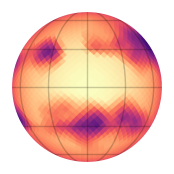

In [7]:
import jax
import matplotlib.pyplot as plt
from spotter.experimental import viz

y = gp.sample(jax.random.PRNGKey(6), shape=(1,))[0]
y = 1.0 - y.clip(0.0, 1.0)

plt.figure(figsize=(2, 2))
viz.show(y, inclination=0.0, u=u)

As before, let's see how surfaces look for different values of the length scale.

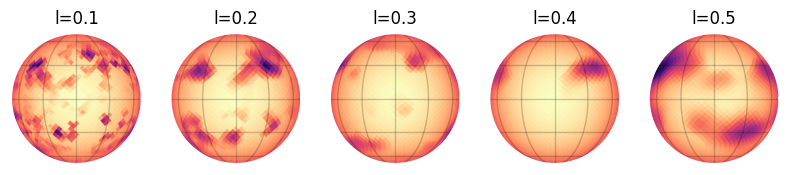

In [8]:
from matplotlib import gridspec

lenght_scales = [0.1, 0.2, 0.3, 0.4, 0.5]
gridspec.GridSpec(1, 6)
plt.figure(figsize=(12, 2))

for i, l in enumerate(lenght_scales):
    kernel = kernels.ActiveLatitude(
        kernel=0.1 * tinygp.kernels.Matern52(l, distance=kernels.GreatCircleDistance()),
        latitude=0.5,
        sigma=0.2,
        symetric=True,
    )
    gp = tinygp.GaussianProcess(kernel, X)
    y = gp.sample(jax.random.PRNGKey(i), shape=(1,))[0]
    y = 1.0 - y.clip(0.0, 1.0)
    plt.subplot(1, 6, i + 1)
    viz.show(y, inclination=0.0, u=u)
    plt.title(f"l={l}")

We note that the kernel doesn't have to be symmetric in latitudes.

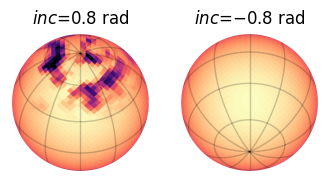

In [9]:
kernel = kernels.ActiveLatitude(
    kernel=0.1 * tinygp.kernels.Matern52(0.1, distance=kernels.GreatCircleDistance()),
    latitude=jnp.pi / 2,
    sigma=0.2,
    symetric=False,
)
gp = tinygp.GaussianProcess(kernel, X)

y = gp.sample(jax.random.PRNGKey(0), shape=(1,))[0]
y = 1.0 - y.clip(0.0, 1.0)

plt.figure(figsize=(4, 2))
ax = plt.subplot(121)
viz.show(y, inclination=0.8, u=u, ax=ax)
ax.set_title("$inc$=0.8 rad")

ax = plt.subplot(122)
viz.show(y, inclination=-0.8, u=u, ax=ax)
_ = ax.set_title("$inc$=$-0.8$ rad")